In [1]:
import pandas as pd
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from env import host, user, password
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.zillow17()
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,None,None,None,Central,Single Family Residential,None,None
1,1072280,10711877,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,None,None,Central,Single Family Residential,None,None
2,1340933,10711888,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,None,None,Central,Single Family Residential,None,None
3,1878109,10711910,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,None,None,None,Central,Single Family Residential,None,None
4,2190858,10711923,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,None,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,775695,167686999,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,-0.068632,2017-02-28,None,None,None,None,Single Family Residential,None,None
77570,2863262,167687739,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.360020,2017-03-03,None,None,None,None,Condominium,None,None
77571,1372384,167687839,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.038797,2017-05-31,None,None,None,None,Single Family Residential,None,None
77572,2758757,167688532,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,NaN,0.006706,2017-02-03,Central,None,None,Central,Condominium,None,None


In [3]:
df = df.set_index("parcelid")

In [4]:
df.to_csv("zillow.csv")

In [5]:
df = pd.read_csv('zillow.csv')
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,10711855,1087254,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,10711877,1072280,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,10711888,1340933,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,10711910,1878109,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,...,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10711923,2190858,NaN,NaN,NaN,2.0,4.0,NaN,8.0,2.0,...,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,167686999,775695,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,-0.068632,2017-02-28,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77570,167687739,2863262,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.360020,2017-03-03,NaN,NaN,NaN,NaN,Condominium,NaN,NaN
77571,167687839,1372384,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.038797,2017-05-31,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77572,167688532,2758757,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,NaN,0.006706,2017-02-03,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [6]:
df = wrangle.wrangle_zillow()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 10711855 to 162960814
Data columns (total 25 columns):
bathrooms                 71818 non-null float64
bedrooms                  71818 non-null int64
property_quality          71818 non-null int64
sqft                      71818 non-null float64
fips                      71818 non-null int64
latitude                  71818 non-null float64
longitude                 71818 non-null float64
lot_sqft                  71818 non-null float64
rawcensustractandblock    71818 non-null float64
regionidcity              71818 non-null float64
regionidcounty            71818 non-null int64
zip_code                  71818 non-null int64
roomcnt                   71818 non-null int64
unitcnt                   71818 non-null int64
yearbuilt                 71818 non-null int64
structure_value           71818 non-null float64
taxvaluedollarcnt         71818 non-null float64
assessmentyear            71818 non-null int64
land_value      

In [8]:
df.describe()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,roomcnt,unitcnt,yearbuilt,structure_value,taxvaluedollarcnt,assessmentyear,land_value,taxamount,logerror,home_age
count,71818.000000,71818.000000,71818.000000,71818.000000,71818.000000,7.181800e+04,7.181800e+04,7.181800e+04,7.181800e+04,71818.000000,...,71818.000000,71818.0,71818.000000,7.181800e+04,7.181800e+04,71818.0,7.181800e+04,71818.000000,71818.000000,71818.000000
mean,2.272822,3.016765,6.758431,1741.973753,6049.318527,3.400713e+07,-1.182004e+08,2.775619e+04,6.049622e+07,33507.591913,...,1.565833,1.0,1969.568813,1.827604e+05,4.676457e+05,2016.0,2.848853e+05,5710.566725,0.016332,51.431187
std,0.916359,0.990155,1.350214,873.320788,21.083111,2.673508e+05,3.642891e+05,1.184843e+05,2.092536e+05,45986.851085,...,2.884754,0.0,22.904501,1.806905e+05,4.579664e+05,0.0,3.264763e+05,5339.828381,0.164181,22.904501
min,1.000000,1.000000,1.000000,501.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,...,0.000000,1.0,1878.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420,5.000000
25%,2.000000,2.000000,6.000000,1172.000000,6037.000000,3.381053e+07,-1.184182e+08,5.985000e+03,6.037400e+07,12447.000000,...,0.000000,1.0,1954.000000,8.438700e+04,2.059478e+05,2016.0,8.391725e+04,2695.752500,-0.023637,34.000000
50%,2.000000,3.000000,7.000000,1517.000000,6037.000000,3.402124e+07,-1.181685e+08,7.265000e+03,6.037621e+07,25218.000000,...,0.000000,1.0,1971.000000,1.355560e+05,3.563740e+05,2016.0,2.029085e+05,4404.550000,0.006585,50.000000
75%,3.000000,4.000000,7.000000,2056.000000,6059.000000,3.417671e+07,-1.179179e+08,1.061925e+04,6.059052e+07,45457.000000,...,0.000000,1.0,1987.000000,2.157475e+05,5.634630e+05,2016.0,3.644505e+05,6802.257500,0.038174,67.000000
max,10.000000,11.000000,12.000000,12039.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,...,14.000000,1.0,2016.000000,3.348387e+06,4.993132e+06,2016.0,4.847224e+06,142488.690000,3.394544,143.000000


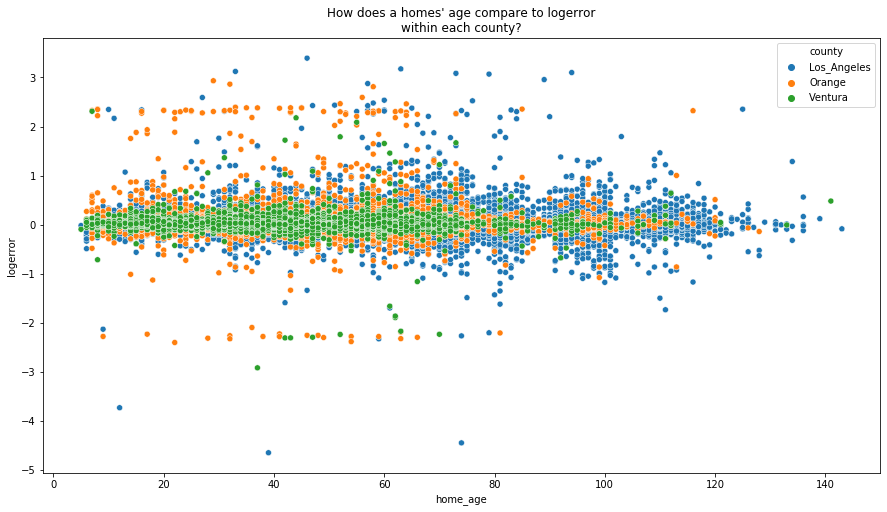

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='home_age', y='logerror',
               data=df, hue='county')
plt.title("How does a homes' age compare to logerror\nwithin each county?")
plt.show()

In [11]:
df['structure_dollar_per_sqft'] = df.structure_value / df.sqft

In [12]:
df['land_dollar_per_sqft'] = df.land_value / df.lot_sqft

In [14]:
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [15]:
df.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,land_value,taxamount,logerror,transactiondate,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,6.037113e+07,12447.0,...,374484.0,7659.36,-0.007357,2017-07-07,Los_Angeles,49,q2,118.488372,40.891461,1.5
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,6.037113e+07,12447.0,...,407000.0,8123.91,0.021066,2017-08-29,Los_Angeles,49,q3,134.431456,45.047039,2.0
10711888,2.0,4,8,1882.0,6037,34222491.0,-118616854.0,9800.0,6.037113e+07,12447.0,...,285332.0,6673.24,0.077174,2017-04-04,Los_Angeles,49,q4,136.870882,29.115510,2.0
10711910,2.0,3,8,1477.0,6037,34221864.0,-118615739.0,11285.0,6.037113e+07,12447.0,...,20063.0,1116.46,-0.041238,2017-03-17,Los_Angeles,61,q1,39.247123,1.777847,1.5
10711923,2.0,4,8,1918.0,6037,34220619.0,-118615253.0,11239.0,6.037113e+07,12447.0,...,247590.0,5239.85,-0.009496,2017-03-24,Los_Angeles,61,q2,87.522941,22.029540,2.0


In [19]:
df.structure_dollar_per_sqft.describe()

count    71818.000000
mean        99.712240
std         59.344098
min          0.039833
25%         63.242333
50%         92.011624
75%        124.423232
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64

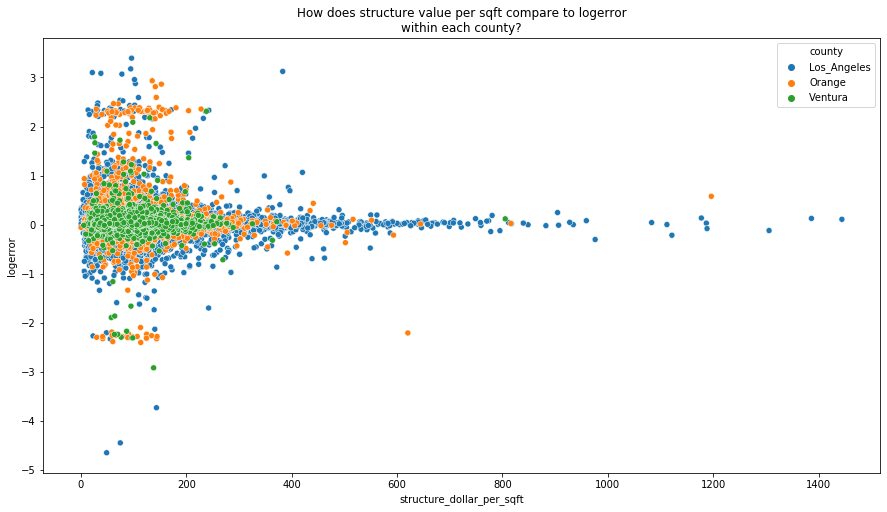

In [23]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror',
               data=df, hue='county')
plt.title("How does structure value per sqft compare to logerror\nwithin each county?")
plt.show()

In [20]:
df.land_dollar_per_sqft.describe()

count    71818.000000
mean        41.152864
std         60.266310
min          0.003023
25%          6.402294
50%         25.494922
75%         52.141033
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64

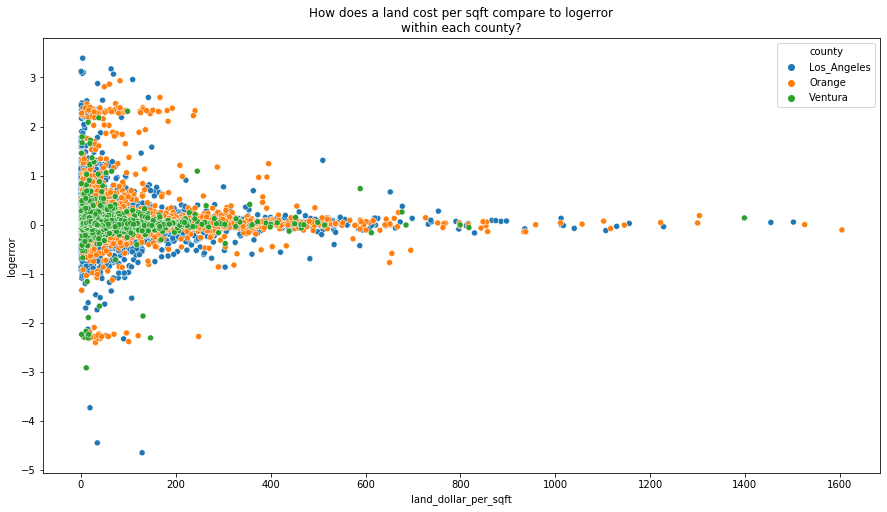

In [24]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='land_dollar_per_sqft', y='logerror',
               data=df, hue='county')
plt.title("How does a land cost per sqft compare to logerror\nwithin each county?")
plt.show()

In [ ]:
### Takeaways

In [17]:
df.bed_bath_ratio.describe()

count    71818.000000
mean         1.450920
std          0.562184
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64

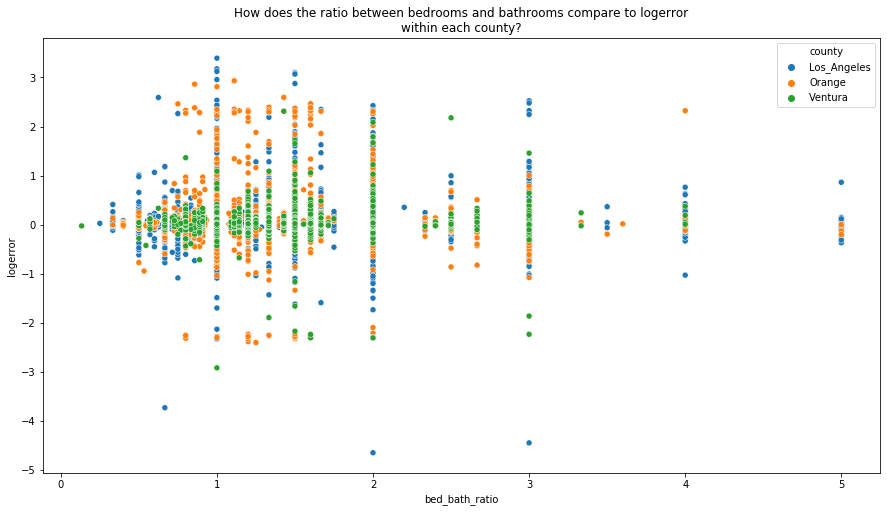

In [25]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='bed_bath_ratio', y='logerror',
               data=df, hue='county')
plt.title("How does the ratio between bedrooms and bathrooms compare to logerror\nwithin each county?")
plt.show()

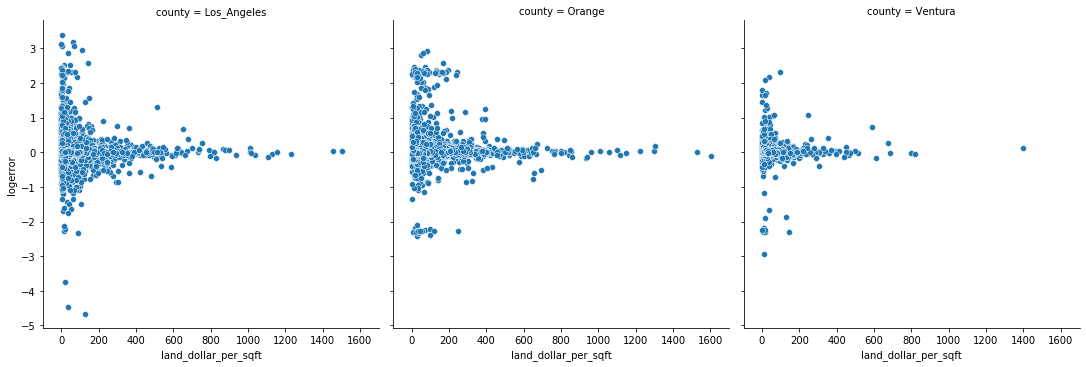

In [31]:
sns.relplot(x="land_dollar_per_sqft", y="logerror", col="county", data=df)

In [32]:
df[df['logerror']<-1]

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,rawcensustractandblock,regionidcity,...,land_value,taxamount,logerror,transactiondate,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,,
10722365,3.0,2,8,2000.0,6037,34200000.0,-118631000.0,7265.0,6.037134e+07,12447.0,...,137934.0,5191.12,-3.737018,2017-03-31,Los_Angeles,12,q1,143.240000,18.986098,0.666667
10737070,6.0,6,7,5256.0,6037,34162535.0,-118653888.0,128020.0,6.037800e+07,38980.0,...,1273247.0,28924.83,-1.702338,2017-07-11,Los_Angeles,61,q1,242.246385,9.945688,1.000000
10797583,6.0,6,6,2586.0,6037,34177793.0,-118547123.0,20808.0,6.037139e+07,12447.0,...,171973.0,6073.17,-1.016539,2017-01-31,Los_Angeles,71,q1,121.752127,8.264754,1.000000
10860623,2.0,3,6,1571.0,6037,34153204.0,-118435442.0,5538.0,6.037141e+07,12447.0,...,72580.0,1353.25,-2.271428,2017-06-15,Los_Angeles,74,q1,22.889879,13.105814,1.500000
10864240,2.0,2,8,2139.0,6037,34146992.0,-118462970.0,5186.0,6.037142e+07,12447.0,...,466129.0,7117.00,-2.331727,2017-08-16,Los_Angeles,59,q1,55.518934,89.882183,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17142286,2.5,4,7,2122.0,6111,34230362.0,-118983672.0,7726.0,6.111005e+07,51239.0,...,116272.0,3471.06,-2.311473,2017-08-15,Ventura,43,q1,98.418944,15.049443,1.600000
17166856,1.0,3,7,1759.0,6111,34182045.0,-119174226.0,6000.0,6.111004e+07,13150.0,...,97001.0,2643.16,-2.238112,2017-08-29,Ventura,70,q1,69.762365,16.166833,3.000000
17171528,1.0,3,7,1026.0,6111,34154592.0,-119218665.0,2450.0,6.111004e+07,13150.0,...,320218.0,5803.48,-1.866832,2017-07-13,Ventura,62,q1,64.024366,130.701224,3.000000


In [34]:
df[df['logerror'] < -1].fips.value_counts()

6037    30
6059    26
6111    11
Name: fips, dtype: int64

In [35]:
df.logerror_quartiles.value_counts()

q4    17955
q1    17955
q3    17954
q2    17954
Name: logerror_quartiles, dtype: int64